### Use it for random-local failure and recovery 
### number of nodes to remove = 65 (for flood)


In [1]:
import pandas as pd
import numpy as np
import yaml
import copy
import matplotlib
import matplotlib.pyplot as plt
import warnings
import random
import collections
warnings.filterwarnings("ignore")
matplotlib.use('TkAgg')
import networkx as nx
%matplotlib inline

In [2]:
pwd

'/Users/nishant/Desktop/PNNL-2019/Topology_Based_Failure'

In [3]:
def import_network(path):
    """
    path = path to network data
    df = imported network data as a pandas dataframe
    """
    
    df = pd.read_csv(path, sep=" ", 
                 header=None,
                 names=['layer','node1','node2','weight'])
    
    return df


def create_edge_list(df, n_layers):
    
    edges = []
    for i in range(n_layers):
        edges.append(list(zip(df["node1"][df.layer==i+1], df["node2"][df.layer==i+1])))
    
    return edges

def create_node_list(df, which_layer):
    
    temp = list(set(df.node1[df.layer==which_layer]))
    temp2 = list(set(df.node2[df.layer==which_layer]))
    node_list = list(set(temp+temp2))
    
    return node_list


def calculate_gc_size(graph):
    """
    gc = giant component
    """
    
    gc_size = [len(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)][0]
    
    return gc_size


def normalize_gc_list(gc_list):
    "calculates gc size as a fraction of initial gc"
    
    return np.array(gc_list)/max(gc_list)



In [4]:
if __name__ == "__main__":
    
    config_file = '/Users/nishant/Desktop/PNNL-2019/config.yml'
    
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
        path = config['path']
        n_layers = config['n_layers']
        df = import_network(path)
        edge_list = create_edge_list(df, n_layers)
    

In [5]:
"""CREATE EDGE LIST"""

edge_list_1 = edge_list[0]
edge_list_2 = edge_list[1]
edge_list_3 = edge_list[2]

agg_edges = list(set(edge_list_1 + edge_list_2 + edge_list_3))

print(len(edge_list_1))
print(len(edge_list_2))
print(len(edge_list_3))
print(len(agg_edges))

312
83
46
430


In [6]:
"""CREATE NODE LISTS"""

node_list_1 = create_node_list(df, 1)
node_list_2 = create_node_list(df, 2)
node_list_3 = create_node_list(df, 3)

print(len(node_list_1))
print(len(node_list_2))
print(len(node_list_3))

271
83
45


In [7]:
# def create_mplex(e_1, e_2, e_3, n_1, n_2, n_3):
    
#     t_nodes = 369 #total distinct nodes
    
#     node_list_mplex = list(np.hstack((np.array(n_1), (np.array(n_2) + t_nodes), 
#                                     np.array(n_3)+2*t_nodes)))
    
#     edge_list_1_mplex = np.array(e_1)
#     edge_list_2_mplex = np.array(e_2) + 369
#     edge_list_3_mplex = np.array(e_3) + 2*369
    
#     G = nx.Graph()
    
#     """Add Edges"""
    
#     G.add_edges_from(edge_list_1_mplex)
#     G.add_edges_from(edge_list_2_mplex)
#     G.add_edges_from(edge_list_3_mplex)
    
#     """Add Intralayer Edges"""
    
#     intra_layer_edges = []

#     for node in n_1:
#         if node in n_2:
#             intra_layer_edges.append((node,node+ t_nodes))
#         if node in n_3:
#             intra_layer_edges.append((node,node+ 2*t_nodes))
        
#     for node2 in n_2:
#         if node2 in n_3:
#             intra_layer_edges.append((node2 + t_nodes, node2 + 2*t_nodes))
    
#     G.add_edges_from(intra_layer_edges)
    
#     return G
    

In [8]:
G1 = nx.Graph()
G1.add_edges_from(edge_list_1)

G2 = nx.Graph()
G2.add_edges_from(edge_list_2)

G3 = nx.Graph()
G3.add_edges_from(edge_list_3)

agg_G = nx.Graph()
agg_G.add_edges_from(agg_edges)

#mplex_G = create_mplex(edge_list_1, edge_list_2, edge_list_3, node_list_1, node_list_2, node_list_3)

In [9]:
"""PICK THE GRAPH TO ANALYZE """

which_graph = 4

"""
which_graph:

1: layer 1 (underground)
2: layer 2 (overground)
3: layer 3 (DLR)
4: Aggregated 
5: Mplex (not working here)

"""


if which_graph == 1:
    G = G1
    node_list = node_list_1

elif which_graph == 2:
    G = G2
    node_list = node_list_2
    
elif which_graph == 3:
    G = G3
    node_list = node_list_3
    
elif which_graph == 4:
    G = agg_G
    node_list = list(G.nodes())
    
# elif which_graph == 5:
#     G = mplex_G
#     node_list = list(G.nodes())


edge_list = list(G.edges)

print('Nodes: ', len(node_list))
print('Edges: ', len(edge_list))

Nodes:  369
Edges:  430


In [10]:
"""
calculate initial giant component (gc) size
"""

initial_gc_size = calculate_gc_size(G)
print(initial_gc_size)


369


In [11]:
"""Create Ensemble Lists of Nodes to Remove for Random Failure"""

df_nodes = pd.read_csv('london_transport_nodes.txt', sep=" ", 
                 header=None,
                 names=['nodeID','nodeLabel','nodeLat','nodeLong'])

df_nodes.head()

,nodeID,nodeLabel,nodeLat,nodeLong
0,0,abbeyroad,51.531952,0.003738
1,1,westham,51.528526,0.005332
2,2,actoncentral,51.508758,-0.263416
3,3,willesdenjunction,51.532234,-0.243895
4,4,actontown,51.503071,-0.280288


In [13]:
"""Create Ensemble Lists of Nodes to Remove for Random Failure"""

#Step 1: Calculate distance of the randomly chosen node to all other nodes
#Step2: Extract the nearest 65 nodes and append to sorted_nodes_by_random

n_iter = 100
sorted_nodes_by_random = []

df_nodes = pd.read_pickle('/Users/nishant/Desktop/PNNL-2019/Topology_Based_Failure/df_node_dist.pkl')

r = random.sample(range(369), n_iter)
print(r)
print(type(r))

for i in range(n_iter): 
    
    node = r[i]
    
    closest_nodes = df_nodes.loc[node, str(0):].sort_values()
    sorted_nodes_by_random.append(list(closest_nodes.index[:65].astype(int)))

    
# for i in range(n_iter):

#     r = random.sample(range(len(df_nodes)-1), 1)
#     print(r)
    
#     for j in range(len(df_nodes)):
#         df_nodes[str(j)] = 0
#         df_nodes[str(j)].iloc[r] = np.sqrt(np.square(df_nodes['nodeLat'].iloc[r] - df_nodes['nodeLat'].iloc[j]) + \
#                (np.square(df_nodes['nodeLong'].iloc[r] - df_nodes['nodeLong'].iloc[j])))


#     closest_nodes = (df_nodes.loc[r, str(0):]).iloc[0]
#     sorted_nodes_by_random.append(closest_nodes.index[:65].astype(int))



[8, 298, 147, 34, 346, 5, 332, 367, 83, 16, 216, 224, 320, 148, 209, 125, 318, 141, 62, 277, 175, 201, 270, 253, 291, 267, 234, 323, 33, 152, 178, 172, 101, 219, 240, 156, 341, 244, 203, 241, 360, 157, 316, 210, 95, 285, 182, 122, 86, 331, 345, 145, 61, 246, 261, 177, 204, 108, 98, 304, 59, 336, 180, 31, 247, 77, 236, 165, 67, 223, 183, 349, 211, 87, 117, 42, 58, 79, 220, 275, 208, 337, 132, 229, 135, 22, 302, 96, 120, 344, 15, 218, 110, 102, 164, 225, 207, 188, 215, 121]
<class 'list'>


In [107]:
# """Create Ensemble Lists of Nodes to Remove for Random Failure"""

# node_list = list(G.nodes())
# node_list_copy = copy.deepcopy(node_list)

# #n_nodes_to_remove = len(node_list)
# n_nodes_to_remove = 65

# n_iter = 10
# sorted_nodes_by_random = []

# for i in range(10):
#     sorted_nodes_by_random.append(random.sample(node_list_copy, n_nodes_to_remove))


# print(len(sorted_nodes_by_random[0]))
# print(len(sorted_nodes_by_random))

## FAILURE PART OF THE PLOT

In [14]:
def remove_nodes(G, nodes_to_remove, edge_list):

    """
    nodes_to_remove: list

    edge_list: for this layer the orginal list of tuples (edges)
                e.g. [(1,77), (4,13)..]

    returns list of GC sizes and the graph remaining 
    """

    
    """initialize updated_edges list with original edge_list"""
    updated_edges = copy.deepcopy(edge_list)
    
    """initialize updated_G with orginial graph G"""
    updated_G = copy.deepcopy(G)
    initial_gc_size = calculate_gc_size(G)
    
    """empty list which will capture gc size as the network fails"""
    gc_list = []
    gc_list.append(initial_gc_size)
    count = 0

    for node in nodes_to_remove:
        
        updated_G.remove_edges_from(list(G.edges(node)))
        
        gc_list.append(calculate_gc_size(updated_G))
        updated_G.remove_node(node)
    
        count +=1
    
    #else:
    if len(nodes_to_remove) == len(node_list):
        gc_list.append(0)
    
    return gc_list, updated_G, count


In [15]:
"""RANDOM FAILURE"""

gc_list_by_random = []
updated_G_list = []

for i in range(n_iter):
    nodes_to_remove = sorted_nodes_by_random[i]
    gc_temp, updated_G_temp, count = remove_nodes(G, nodes_to_remove, edge_list)
    gc_list_by_random.append(normalize_gc_list(gc_temp))
    updated_G_list.append(updated_G_temp)

print(len(gc_list_by_random[0]))

66


In [16]:
gc_list_by_random[0]

array([1.        , 0.99728997, 0.99457995, 0.99186992, 0.98915989,
       0.98644986, 0.98373984, 0.98102981, 0.97831978, 0.97560976,
       0.97289973, 0.9701897 , 0.96747967, 0.96476965, 0.96205962,
       0.95934959, 0.95663957, 0.95392954, 0.95121951, 0.94850949,
       0.94579946, 0.94308943, 0.9403794 , 0.93766938, 0.93495935,
       0.93224932, 0.9295393 , 0.92682927, 0.92411924, 0.92140921,
       0.91869919, 0.91598916, 0.91327913, 0.91056911, 0.90785908,
       0.90243902, 0.90243902, 0.899729  , 0.89701897, 0.89430894,
       0.89159892, 0.88888889, 0.88617886, 0.88346883, 0.88075881,
       0.84823848, 0.84552846, 0.84281843, 0.8401084 , 0.83739837,
       0.83468835, 0.83197832, 0.82926829, 0.82384824, 0.82113821,
       0.82113821, 0.81842818, 0.81571816, 0.8102981 , 0.8102981 ,
       0.80758808, 0.80487805, 0.80216802, 0.7398374 , 0.73712737,
       0.70460705])

## RECOVERY PART OF THE PLOT

In [17]:
def add_nodes(G, updated_G, nodes_to_add, edge_list):
    
    """re: recovery
    """
    
    """initialize the graph object with the graph (updated_G) remaining post failure"""
    re_updated_G = copy.deepcopy(updated_G)
    edges_to_add = copy.deepcopy(edge_list)
     
    """empty list which will capture gc size as the network recovers"""
    re_gc_list = []
    count = 0
    initial_gc_size = calculate_gc_size(G)
    
    if len(nodes_to_add) == len(node_list):
        re_gc_list.append(0)
    
    for node in nodes_to_add:
        
        re_updated_G.add_node(node)
        re_updated_G.add_edges_from(list(G.edges(node)))
        re_gc_list.append(calculate_gc_size(re_updated_G))
    
    
    re_gc_list.append(initial_gc_size)
    
    return re_gc_list, re_updated_G, count


In [18]:
"""RECOVERY - Nodes to Add"""

re_gc_list_by_random = []
re_updated_G_list = []

for i in range(n_iter):
    nodes_to_add = sorted_nodes_by_random[i]
    re_gc_temp, re_updated_G_temp, count = add_nodes(G, updated_G_list[i], nodes_to_add, edge_list)
    re_gc_list_by_random.append(normalize_gc_list(re_gc_temp))
    re_updated_G_list.append(updated_G_temp)

print(len(re_gc_list_by_random[0]))

66


In [19]:
re_gc_list_by_random[1]

array([0.68563686, 0.68563686, 0.68563686, 0.68563686, 0.68563686,
       0.68563686, 0.68563686, 0.68563686, 0.68563686, 0.68563686,
       0.68563686, 0.68563686, 0.68563686, 0.68563686, 0.68563686,
       0.68563686, 0.68563686, 0.68563686, 0.68563686, 0.68563686,
       0.68563686, 0.68563686, 0.68563686, 0.68563686, 0.68563686,
       0.68563686, 0.68563686, 0.68563686, 0.68563686, 0.68563686,
       0.68563686, 0.68563686, 0.68563686, 0.68563686, 0.68563686,
       0.68563686, 0.68563686, 0.70189702, 0.70189702, 0.70189702,
       0.70189702, 0.70189702, 0.70189702, 0.72086721, 0.72086721,
       0.72086721, 0.72086721, 0.96747967, 0.96747967, 0.96747967,
       0.9701897 , 0.9701897 , 0.9701897 , 0.9701897 , 0.9701897 ,
       0.9701897 , 0.97289973, 0.97831978, 0.97831978, 0.98102981,
       0.98102981, 0.98102981, 1.        , 1.        , 1.        ,
       1.        ])

In [20]:
"""Calculate Ensemble Mean - Random Failure"""

gc_array_by_random = np.array(gc_list_by_random)
re_gc_array_by_random = np.array(re_gc_list_by_random)

gc_list_by_random_mean = np.mean(gc_array_by_random, axis=0)
re_gc_list_by_random_mean = np.mean(re_gc_array_by_random, axis=0)



In [21]:
"""Save GC size List of Lists"""

# np.save('agg_gc_list_by_random_local', gc_list_by_random)
# np.save('agg_re_gc_list_by_random_local', re_gc_list_by_random)


# """Save Ensemble Mean (a single list)"""

# np.save('agg_gc_list_by_random_local_mean', gc_list_by_random_mean)
# np.save('agg_re_gc_list_by_random_local_mean', re_gc_list_by_random_mean)

'Save GC size List of Lists'

In [22]:
pwd

'/Users/nishant/Desktop/PNNL-2019/Topology_Based_Failure'

## PLOTTING

In [23]:
"""fraction of nodes removed on x-axis"""

node_frac = np.arange(len(gc_list_by_random[0])) 

print(len(node_frac))

66


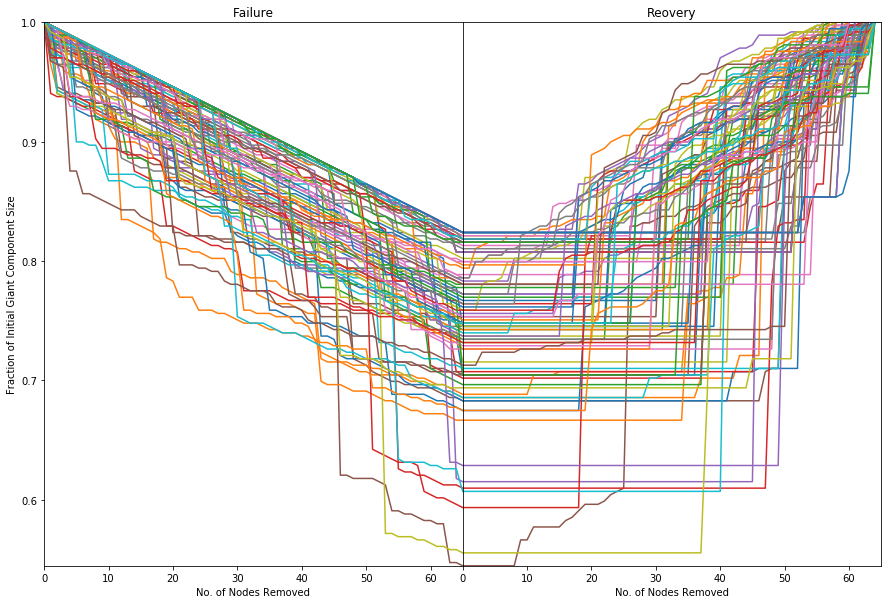

In [24]:
plt.figure(figsize=(15,10))

for i in range(n_iter):
    
    plt.subplot(1,2,1)
    plt.plot(node_frac, gc_list_by_random[i], label='')
    
    #plt.ylim(top=1, bottom=0)
    #plt.xlim(left=0, right=1)
    plt.xlabel('No. of Nodes Removed')
    plt.ylabel('Fraction of Initial Giant Component Size')
    plt.title('Failure')
    plt.margins(x=0, y=0)
    #plt.legend()

    plt.subplot(1,2,2)
    plt.plot(node_frac,re_gc_list_by_random[i], label='')

    #plt.plot(node_frac, node_frac, '--')
    #plt.xlim(left=0)
    #plt.ylim(bottom=0, top=1)
    plt.yticks([])
    #plt.xticks([0.2, 0.4, 0.6, 0.8, 1])
    plt.xlabel('No. of Nodes Removed')
    plt.title('Reovery')
    plt.margins(x=0, y=0)
    #plt.legend()
 

plt.subplots_adjust(wspace=0)
#plt.suptitle('Random Failure (Ensemble N=1000)', y=0.92, fontsize='16')
plt.show()


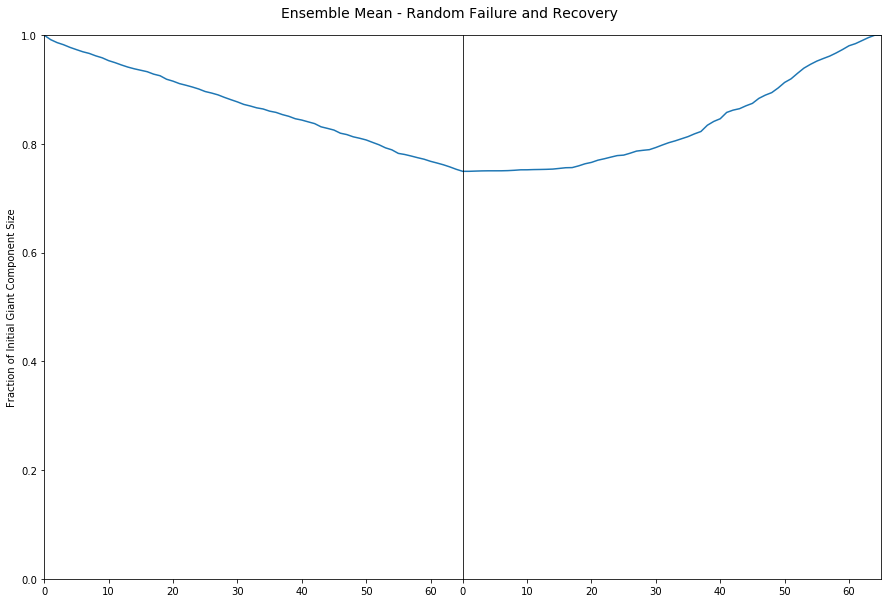

In [25]:
"""Plot Ensemble Mean"""

plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.plot(node_frac, gc_list_by_random_mean, '-', label='#degree')
plt.ylim(top=1, bottom=0)
#plt.xlim(left=0, right=1)
#plt.xlabel('Fraction of nodes added')
plt.ylabel('Fraction of Initial Giant Component Size')
plt.margins(x=0, y=0)
#plt.legend()

plt.subplot(1,2,2)
plt.plot(node_frac,re_gc_list_by_random_mean, label='#degree')
    #plt.plot(node_frac, node_frac, '--')
#plt.xlim(left=0, right=1)
plt.ylim(bottom=0, top=1)
plt.yticks([])
#plt.xticks([0.2, 0.4, 0.6, 0.8, 1])
#plt.xlabel('Fraction of nodes added')
plt.margins(x=0, y=0)
#plt.legend()

plt.subplots_adjust(wspace=0)
plt.suptitle('Ensemble Mean - Random Failure and Recovery', y=0.92, fontsize='14')
plt.show()